In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-05-20 16:56:08--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-05-20 16:56:09--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-05-20 16:56:09--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sn

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

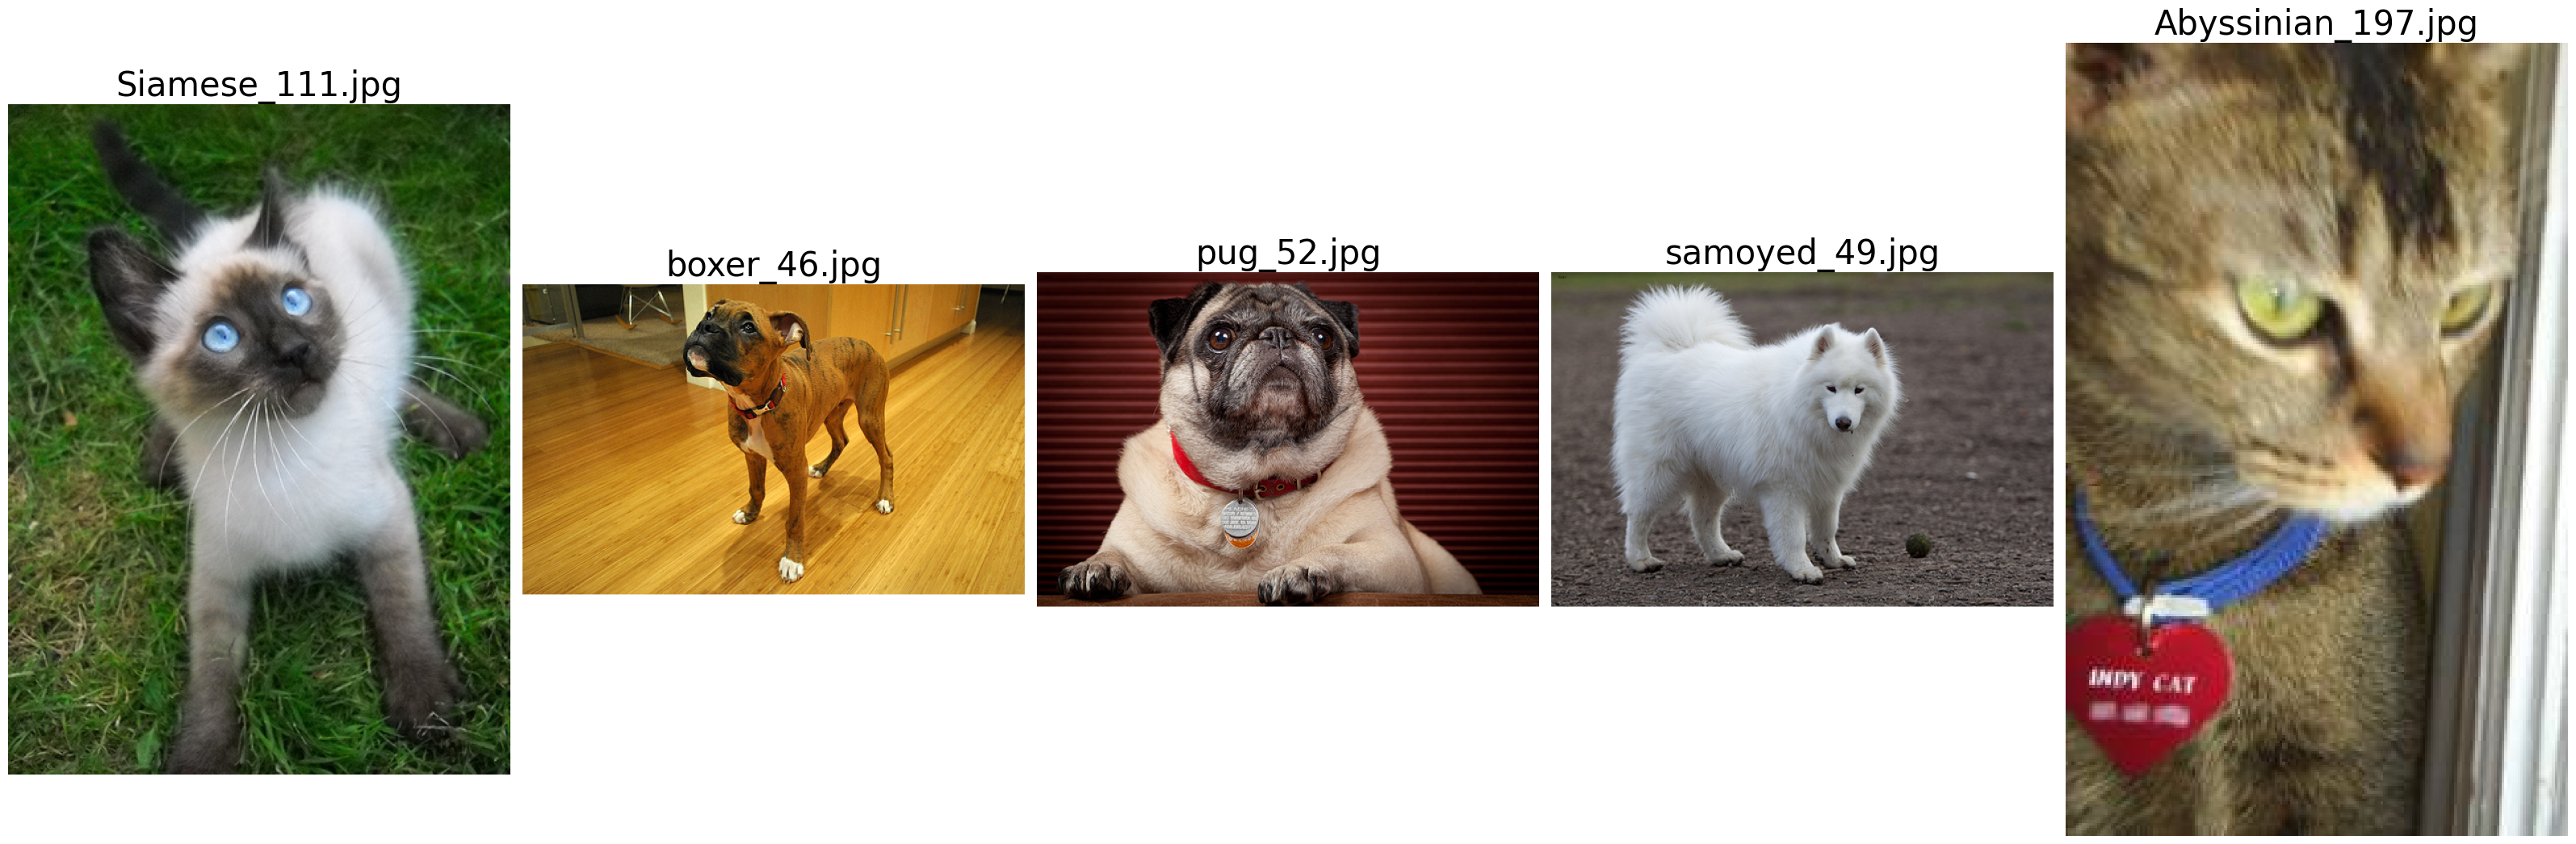

In [5]:
fnames = os.listdir('images')[:5]
display_images([Image.open(os.path.join('images',x)) for x in fnames],titles=fnames,fontsize=30)

In [6]:
for fn in os.listdir('images'):
    cls = fn[:fn.rfind('_')].lower()
    os.makedirs(os.path.join('images',cls),exist_ok=True)
    os.replace(os.path.join('images',fn),os.path.join('images',cls,fn))

In [7]:
num_classes = len(os.listdir('images'))
num_classes

37

In [8]:
import tensorflow as tf

image_size = 224
batch_size = 32

train, test = [
    tf.keras.preprocessing.image_dataset_from_directory(
    'images',
    image_size=(image_size,image_size),
    validation_split=0.2,
    subset=s,
    batch_size=batch_size,
    seed=13)
    for s in ['training','validation']]

class_names = train.class_names

Found 7390 files belonging to 37 classes.
Using 5912 files for training.
Found 7390 files belonging to 37 classes.
Using 1478 files for validation.


In [9]:
for i,l in train:
    print(i.shape,l.shape)
    print(l)
    print('Max intensity = ',np.max(i))
    break

(32, 224, 224, 3) (32,)
tf.Tensor(
[ 9 14 21 15 20 25 31 19 35 22  8 18  7 26 29 27 15  5 21  6 17  5 17 29
  8 10  2  3 18 34 20 34], shape=(32,), dtype=int32)
Max intensity =  255.0


***VGG-16***

In [10]:
vgg_16 = tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
vgg_16_model = tf.keras.models.Sequential()
vgg_16_model.add(tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input))
vgg_16_model.add(vgg_16)
vgg_16_model.add(tf.keras.layers.Flatten())
vgg_16_model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

vgg_16_model.layers[1].trainable = False

In [12]:
vgg_16_model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='adam')
hist = vgg_16_model.fit(train,validation_data=test,epochs=3)

Epoch 1/3
105/185 [================>.............] - ETA: 6s - loss: 22.4365 - acc: 0.5625

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 19.6178 - acc: 0.6301

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 31s 117ms/step - loss: 19.6178 - acc: 0.6301 - val_loss: 15.4822 - val_acc: 0.7571
Epoch 2/3
105/185 [================>.............] - ETA: 5s - loss: 4.1514 - acc: 0.9119

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 4.6069 - acc: 0.9056

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 19s 100ms/step - loss: 4.6069 - acc: 0.9056 - val_loss: 16.1497 - val_acc: 0.7848
Epoch 3/3
105/185 [================>.............] - ETA: 5s - loss: 1.7461 - acc: 0.9554

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 1.7221 - acc: 0.9567

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 18s 96ms/step - loss: 1.7221 - acc: 0.9567 - val_loss: 17.0102 - val_acc: 0.7801


***VGG-16 Top 3 Accuracy***

In [13]:
correct = 0
total = 0
for t,l in test:
    r = vgg_16_model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=3)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

Corrupt JPEG data: premature end of data segment


tf.Tensor(0.9607577807848444, shape=(), dtype=float64)


***VGG-16 Top 5 Accuracy***

In [14]:
correct = 0
total = 0
for t,l in test:
    r = vgg_16_model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=5)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

Corrupt JPEG data: premature end of data segment


tf.Tensor(0.9844384303112313, shape=(), dtype=float64)


***VGG-19***

In [15]:
vgg_19 = tf.keras.applications.VGG19(include_top=False,input_shape=(224,224,3))

80134624/80134624 [==============================] - 0s 0us/step


In [17]:
vgg_19_model = tf.keras.models.Sequential()
vgg_19_model.add(tf.keras.layers.Lambda(tf.keras.applications.vgg19.preprocess_input))
vgg_19_model.add(vgg_19)
vgg_19_model.add(tf.keras.layers.Flatten())
vgg_19_model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

vgg_19_model.layers[1].trainable = False

In [20]:
vgg_19_model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='adam')
hist = vgg_19_model.fit(train,validation_data=test,epochs=3)

Epoch 1/3
103/185 [===============>..............] - ETA: 6s - loss: 6.6063 - acc: 0.8865

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 6.9535 - acc: 0.8840

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 21s 108ms/step - loss: 6.9535 - acc: 0.8840 - val_loss: 20.5251 - val_acc: 0.7625
Epoch 2/3
104/185 [===============>..............] - ETA: 6s - loss: 3.7485 - acc: 0.9384

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 3.6968 - acc: 0.9374

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 20s 104ms/step - loss: 3.6968 - acc: 0.9374 - val_loss: 20.5538 - val_acc: 0.7909
Epoch 3/3
103/185 [===============>..............] - ETA: 7s - loss: 2.0516 - acc: 0.9627

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 2.0704 - acc: 0.9633

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 20s 106ms/step - loss: 2.0704 - acc: 0.9633 - val_loss: 20.9527 - val_acc: 0.7821


***VGG-19 Top 3 Accuracy***

In [21]:
correct = 0
total = 0
for t,l in test:
    r = vgg_19_model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=3)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

Corrupt JPEG data: premature end of data segment


tf.Tensor(0.9648173207036536, shape=(), dtype=float64)


***VGG-19 Top 5 Accuracy***

In [22]:
correct = 0
total = 0
for t,l in test:
    r = vgg_19_model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=5)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

Corrupt JPEG data: premature end of data segment


tf.Tensor(0.9878213802435724, shape=(), dtype=float64)


***ResNet***

In [23]:
resnet = tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
resnet_model = tf.keras.models.Sequential()
resnet_model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
resnet_model.add(resnet)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

resnet_model.layers[1].trainable = False

In [25]:
resnet_model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='adam')
hist = resnet_model.fit(train,validation_data=test,epochs=3)

Epoch 1/3
105/185 [================>.............] - ETA: 6s - loss: 8.3070 - acc: 0.6664

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 7.4044 - acc: 0.7194

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 25s 106ms/step - loss: 7.4044 - acc: 0.7194 - val_loss: 6.8193 - val_acc: 0.7991
Epoch 2/3
105/185 [================>.............] - ETA: 6s - loss: 1.7691 - acc: 0.9348

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


185/185 [==============================] - ETA: 0s - loss: 1.7220 - acc: 0.9345

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 20s 106ms/step - loss: 1.7220 - acc: 0.9345 - val_loss: 7.0527 - val_acc: 0.8180
Epoch 3/3
105/185 [================>.............] - ETA: 6s - loss: 0.6420 - acc: 0.9673

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/185 [============================>.] - ETA: 0s - loss: 0.6344 - acc: 0.9679

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 19s 102ms/step - loss: 0.6364 - acc: 0.9677 - val_loss: 6.4033 - val_acc: 0.8451


***ResNet Top 3 Accuracy***

In [26]:
correct = 0
total = 0
for t,l in test:
    r = resnet_model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=3)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

Corrupt JPEG data: premature end of data segment


tf.Tensor(0.9702300405953992, shape=(), dtype=float64)


***ResNet Top 5 Accuracy***

In [27]:
correct = 0
total = 0
for t,l in test:
    r = resnet_model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=5)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

Corrupt JPEG data: premature end of data segment


tf.Tensor(0.9939106901217862, shape=(), dtype=float64)


#### ***Двоичная классификация "кошки против собак"***

In [19]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2023-05-20 17:04:43--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   197KB/s    in 2m 6s   

2023-05-20 17:06:49 (190 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [28]:
image_size = 224
batch_size = 32

train_bin, test_bin = [
    tf.keras.preprocessing.image_dataset_from_directory(
    'petfaces',
    image_size=(image_size,image_size),
    validation_split=0.2,
    subset=s,
    batch_size=batch_size,
    seed=13)
    for s in ['training','validation']]

class_names = train_bin.class_names


Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


In [29]:
classmap = tf.constant([1 if n.startswith('cat_') else 0 for n in class_names])

def mapclass(x,y):
    return x,tf.map_fn(lambda t: classmap[t],y)
    
train_bin = train_bin.map(mapclass)
test_bin = test_bin.map(mapclass)

In [30]:
resnet_binary_model = tf.keras.models.Sequential()
resnet_binary_model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
resnet_binary_model.add(resnet)
resnet_binary_model.add(tf.keras.layers.Flatten())
resnet_binary_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

resnet_binary_model.layers[1].trainable = False

In [31]:
resnet_binary_model.compile(loss='binary_crossentropy',metrics=['acc'],optimizer='adam')
hist = resnet_binary_model.fit(train_bin,validation_data=test_bin,epochs=3)

Epoch 1/3
81/81 [==============================] - 12s 95ms/step - loss: 0.0730 - acc: 0.9879 - val_loss: 5.4425e-07 - val_acc: 1.0000
Epoch 2/3
81/81 [==============================] - 7s 79ms/step - loss: 0.0184 - acc: 0.9977 - val_loss: 0.0115 - val_acc: 0.9984
Epoch 3/3
81/81 [==============================] - 7s 80ms/step - loss: 0.0424 - acc: 0.9953 - val_loss: 5.5303e-06 - val_acc: 1.0000


In [32]:
def get_confusion_matrix(model, test):
  pred = model.predict(test_bin, batch_size=batch_size)
  y_true = []
  y_pred = []
  y_pred = [1 * (x>=0.5) for x in pred]

  for x, l in test_bin:
    results = l.numpy()
    for i in results:
      y_true.append(i)
  print(len(y_pred))

  classes = ['cat', 'dog']
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (25,20))
  sn.heatmap(df_cm, annot=True)

21/21 [==============================] - 2s 55ms/step
642


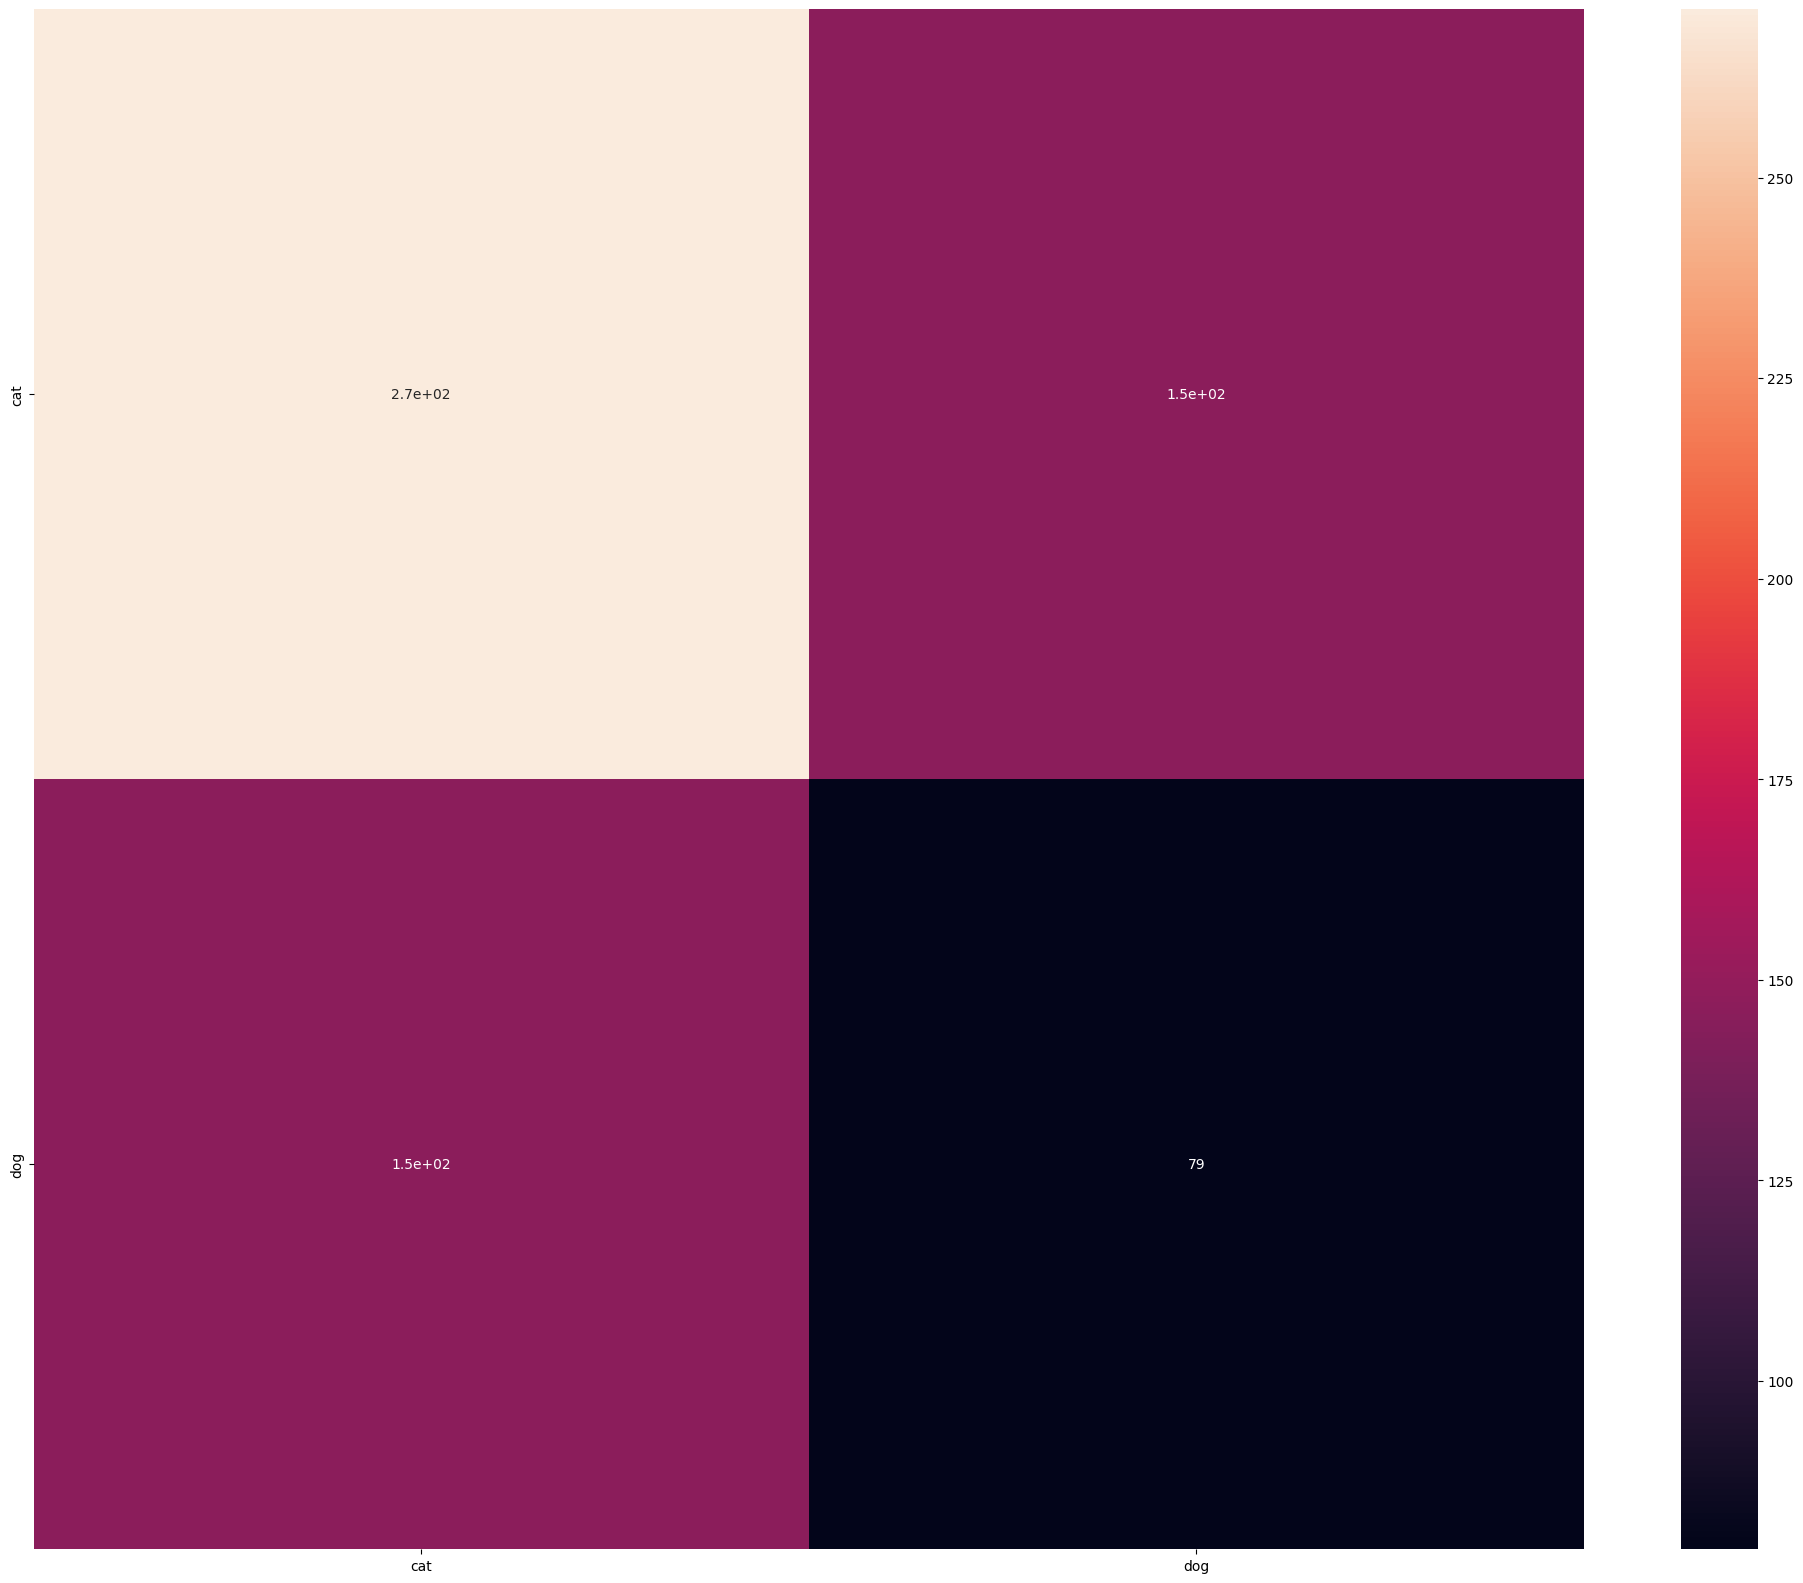

In [33]:
get_confusion_matrix(resnet_binary_model, test_bin)

In [36]:
correct = 0
total = 0
for t,l in test_bin:
    r = resnet_binary_model(t)
    res = tf.nn.in_top_k(predictions=r,targets=l,k=3)
    correct += tf.reduce_sum(tf.cast(res,tf.int32))
    total += len(l)
print(correct/total)

tf.Tensor(0.6495327102803738, shape=(), dtype=float64)
